In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep

sns.set_theme(style="whitegrid")

## Load data

In [2]:
df = pd.read_parquet("../data/scrna_seq_with_embs.pq")
df = df[(~df.embedding.isna()) & (~df.keywords.isna())]
df['pubmed_id'] = df.pubmed_id.map(lambda x: x.split("\n")[0]).astype(int)
embs = np.concatenate([np.atleast_2d(x) for x in df.embedding.values])

In [3]:
# comp_kws = ["bioinformatics", "machine learning", "computational biology", "deep learning"]
comp_kws = ["computational biology", "deep learning", "machine learning"]
comp_df = df[df.keywords.map(lambda kws: any([k.lower() in comp_kws for k in kws]))]
comp_df.shape[0]

180

In [55]:
# for i in range(20):
#     print(", ".join(comp_df.keywords.values[i]))
#     print("---")
#     print(comp_df.title.values[i])
#     print("---")
#     print(comp_df.abstract.values[i])
#     print()

## Generate Computational vs Bio labels with GPT-3

In [50]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.scrape import query_openai

import openai
import os
from tqdm.notebook import tqdm

from dotenv import load_dotenv
load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
title_prompt_full = """
"Microscopic image-based classification of adipocyte differentiation by machine learning."
Q: Does this article propose a new computational method?
A: Yes

---

"Comprehensive multi-omics analysis of the m7G in pan-cancer from the perspective of predictive, preventive, and personalized medicine."
Q: Does this article propose a new computational method?
A: No

---

"Single-cell transcriptomics identifies Keap1-Nrf2 regulated collective invasion in a"
Q: Does this article propose a new computational method?
A: No

---

"A Novel Algorithm for Feature Selection Using Penalized Regression with Applications to Single-Cell RNA Sequencing Data."
Q: Does this article propose a new computational method?
A: Yes

---

"Delineating the transcriptional landscape and clonal diversity of virus-specific CD4"
Q: Does this article propose a new computational method?
A: No

---

"The performance of deep generative models for learning joint embeddings of single-cell multi-omics data."
Q: Does this article propose a new computational method?
A: No

---

"Exploration of the underlying biological differences and targets in ovarian cancer patients with diverse immunotherapy response."
Q: Does this article propose a new computational method?
A: No

---

"Glioma stem cell signature predicts the prognosis and the response to tumor treating fields treatment."
Q: Does this article propose a new computational method?
A: No

"{query}"
Q: Does this article propose a new computational method?
A:
"""

In [35]:
prompt = """
Q: Does this article propose a new computational method? Answer Yes or No.
```
Recent advances in single-cell RNA sequencing (scRNA-seq) have accelerated the development of techniques to classify thousands of cells through transcriptome profiling. As more and more scRNA-seq data become available, supervised cell type classification methods using externally well-annotated source data become more popular than unsupervised clustering algorithms. However, accurate cellular annotation of single cell transcription data remains a significant challenge. Here, we propose a hybrid network structure called TransCluster, which uses linear discriminant analysis and a modified Transformer to enhance feature learning. It is a cell-type identification tool for single-cell transcriptomic maps. It shows high accuracy and robustness in many cell data sets of different human tissues. It is superior to other known methods in external test data set. To our knowledge, TransCluster is the first attempt to use Transformer for annotating cell types of scRNA-seq, which greatly improves the accuracy of cell-type identification.
```
A: Yes

---

Q: Does this article propose a new computational method? Answer Yes or No.
```
Apicobasal cell polarity loss is a founding event in epithelial-mesenchymal transition and epithelial tumorigenesis, yet how pathological polarity loss links to plasticity remains largely unknown. To understand the mechanisms and mediators regulating plasticity upon polarity loss, we performed single-cell RNA sequencing of
In the body, most cells exhibit some form of spatial asymmetry: the compartments within the cell are not evenly distributed, thereby allowing the cells to know whether a surface is on the ‘outside’ or the ‘inside’ of a tissue or organ. In the cells of epithelial tissues, which line most of the cavities and the organs in the body, this asymmetry is known as apical-basal polarity. Maintaining apical-basal polarity in epithelial cells is one of the main barriers that stops cancer cells from invading other tissues, which is the first step of metastasis, the process through which cancer cells leave their tissue of our origin and spread to distant locations in the body. In the fruit fly
```
A: No

---

Q: Does this article propose a new computational method? Answer Yes or No.
```
Single-cell RNA sequencing (scRNA-seq) technologies offer unique opportunities for exploring heterogeneous cell populations. However, in-depth single-cell transcriptomic characterization of complex tissues often requires profiling tens to hundreds of thousands of cells. Such large numbers of cells represent an important hurdle for downstream analyses, interpretation and visualization.
We develop a framework called SuperCell to merge highly similar cells into metacells and perform standard scRNA-seq data analyses at the metacell level. Our systematic benchmarking demonstrates that metacells not only preserve but often improve the results of downstream analyses including visualization, clustering, differential expression, cell type annotation, gene correlation, imputation, RNA velocity and data integration. By capitalizing on the redundancy inherent to scRNA-seq data, metacells significantly facilitate and accelerate the construction and interpretation of single-cell atlases, as demonstrated by the integration of 1.46 million cells from COVID-19 patients in less than two hours on a standard desktop.
SuperCell is a framework to build and analyze metacells in a way that efficiently preserves the results of scRNA-seq data analyses while significantly accelerating and facilitating them.
```
A: Yes

---

Q: Does this article propose a new computational method? Answer Yes or No.
```
{query}
```
A:
"""

In [56]:
title_prompt = """
Q: Does this article propose a new computational method (yes or no)? "Microscopic image-based classification of adipocyte differentiation by machine learning."
A: Yes

---

Q: Does this article propose a new computational method (yes or no)? "Comprehensive multi-omics analysis of the m7G in pan-cancer from the perspective of predictive, preventive, and personalized medicine."
A: No

---

Q: Does this article propose a new computational method (yes or no)? "Exploration of the underlying biological differences and targets in ovarian cancer patients with diverse immunotherapy response."
A: No

---

Q: Does this article propose a new computational method (yes or no)? "A Novel Algorithm for Feature Selection Using Penalized Regression with Applications to Single-Cell RNA Sequencing Data."
A: Yes

---

Q: Does this article propose a new computational method (yes or no)? "{query}"
A:
"""

In [72]:
preds = []
total_tokens = 0
pbar = tqdm(comp_df.title.values)
for title in pbar:
    pbar.set_description(f"Total tokens: {total_tokens}, price: ${total_tokens * 0.02 / 1000:0.3g}")
    pred, n_tokens = query_openai(
        title_prompt_full.format(query=title),
        req_type='completion',
        model="text-davinci-003",
        temperature=0.1,
        max_tokens=1,
        frequency_penalty=0.75
    )

    preds.append(pred)
    if pred is None:
        continue

    total_tokens += n_tokens

  0%|          | 0/180 [00:00<?, ?it/s]

Error in request:  The server is overloaded or not ready yet.


In [81]:
pred_df = comp_df[["title", "abstract", "embedding"]].reset_index().join(DataFrame(dict(pred=preds)))
pred_df.to_parquet("../data/gpt_labeled_data.pq")

In [82]:
# for t in pred_df.title[pred_df.pred == "Yes"]:
#     print(t)

## Predict Computational vs Bio for all articles

On a Paperspace notebook GaussianNB was the best with F-score of ~0.9.

In [4]:
pred_df = pd.read_parquet("../data/gpt_labeled_data.pq")

In [5]:
from sklearn.naive_bayes import GaussianNB

labeled_embs = np.concatenate([np.atleast_2d(x) for x in pred_df.embedding.values])
clf = GaussianNB(priors=[0.5, 0.5]).fit(labeled_embs, pred_df.pred == 'Yes')

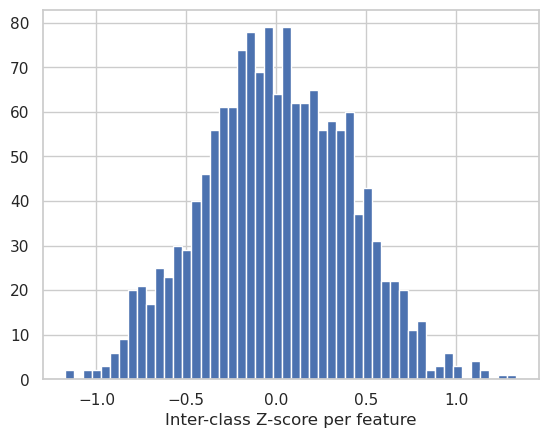

In [6]:
plt.hist(np.diff(clf.theta_, axis=0)[0] / np.sqrt(clf.var_.mean(axis=0)), bins=50);
plt.xlabel("Inter-class Z-score per feature");

In [7]:
df["preds"] = clf.predict(embs)
round(df["preds"].mean(), 3)

0.248

In [8]:
np.random.seed(42)
for ind in np.random.choice(df.index[df.preds], 20):
    print(df.title[ind])
    print("---")
    print(df.abstract[ind])
    print()

doubletD: detecting doublets in single-cell DNA sequencing data.
---
While single-cell DNA sequencing (scDNA-seq) has enabled the study of intratumor heterogeneity at an unprecedented resolution, current technologies are error-prone and often result in doublets where two or more cells are mistaken for a single cell. Not only do doublets confound downstream analyses, but the increase in doublet rate is also a major bottleneck preventing higher throughput with current single-cell technologies. Although doublet detection and removal are standard practice in scRNA-seq data analysis, options for scDNA-seq data are limited. Current methods attempt to detect doublets while also performing complex downstream analyses tasks, leading to decreased efficiency and/or performance.
We present doubletD, the first standalone method for detecting doublets in scDNA-seq data. Underlying our method is a simple maximum likelihood approach with a closed-form solution. We demonstrate the performance of double

## Save to the DB

In [11]:
from tqdm.notebook import tqdm
import requests
import json
HASURA_API_KEY = os.getenv("HASURA_API_KEY")

In [47]:
%%time
insert_cols = ["title", "abstract", "doi", "publication_date", "pubmed_id", "is_computational", "embedding"]
records = df.rename(columns={"preds": "is_computational"})[insert_cols].to_dict(orient="records")
for r in records:
    r['embedding'] = '{' + ",".join([f"{x:.4g}" for x in r["embedding"]]) + '}'

CPU times: user 7.43 s, sys: 4.23 ms, total: 7.43 s
Wall time: 7.44 s


In [49]:
%%time 
res = []
for recs in tqdm(np.array_split(records, 100)):
    r = requests.post(
        "https://sealver.in/hasura/api/rest/scrnaseq_papers/insert",
        json={'objects': list(recs)},
        auth = requests.auth.HTTPBasicAuth('user', HASURA_API_KEY)
    )

    res.append(r.json())

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 5.2 s, sys: 231 ms, total: 5.43 s
Wall time: 1min 53s


In [146]:
# query = """
# mutation insertPapers($objects: [ml_scrnaseq_papers_insert_input!]!) {
#   insert_ml_scrnaseq_papers(objects: $objects) {affected_rows}
# }
# """

# r = requests.post(
#     "https://sealver.in/hasura/v1/graphql", 
#     json={
#         'query': query,
#         'variables': {'objects': records},
#         'operationName': 'insertPapers'
#     },
#     auth = requests.auth.HTTPBasicAuth('user', HASURA_API_KEY)
# )
# r.json()

{'data': {'insert_ml_scrnaseq_papers': {'affected_rows': 1}}}

In [59]:
%%time 
paps = requests.get(
    "https://sealver.in/hasura/api/rest/scrnaseq_papers/get",
    auth = requests.auth.HTTPBasicAuth('user', HASURA_API_KEY)
)

CPU times: user 490 ms, sys: 72.2 ms, total: 562 ms
Wall time: 10.1 s


In [60]:
DataFrame(paps.json()['ml_scrnaseq_papers']).set_index('pubmed_id')

,title,abstract,publication_date,doi,is_computational
pubmed_id,,,,,
36469459,Neuroendocrinology of the lung revealed by sin...,Pulmonary neuroendocrine cells (PNECs) are sen...,2022-12-06,10.7554/eLife.78216\n10.1038/s41467-019-11276-...,False
36469154,Immunosuppressive role of SPP1-CD44 in the tum...,To demonstrate the biological function of Secr...,2022-12-06,10.1007/s00432-022-04498-w\n10.1016/s0002-9610...,False
36468677,CD73-generated extracellular adenosine promote...,Pancreatitis is currently the leading cause of...,2022-12-06,10.1096/fj.202201537R\n10.1097/01.mpa.00002367...,False
36468451,Experimental validation of in silico analysis ...,Colorectal cancer (CRC) is considered one of t...,2022-12-06,10.1002/cam4.5499,False
36468014,Transcriptome profiling of abdominal aortic ti...,Takayasu arteritis (TA) is a chronic granuloma...,2022-12-06,10.3389/fgene.2022.1036233\n10.1002/art.178033...,False
...,...,...,...,...,...
26797145,Lineage-specific enhancers activate self-renew...,Differentiated macrophages can self-renew in t...,2016-01-23,10.1126/science.aad5510,False
26792870,Isolation and gene expression analysis of sing...,It is possible to isolate pure populations of ...,2016-01-23,10.1093/molehr/gaw006,False
26791494,"""Deciphering Archaeal Communities"" Omics Tools...",Archaea constitute one of the three recognized...,2016-01-23,10.1007/978-1-4939-3369-3_1,False


## Generate method description with GPT-3

In [147]:
method_prompt = """
Article:
scWECTA: A weighted ensemble classification framework for cell type assignment based on single cell transcriptome.
Rapid advances in single-cell transcriptome analysis provide deeper insights into the study of tissue heterogeneity at the cellular level. Unsupervised clustering can identify potential cell populations in single-cell RNA-sequencing (scRNA-seq) data, but fail to further determine the identity of each cell. Existing automatic annotation methods using scRNA-seq data based on machine learning mainly use single feature set and single classifier. In view of this, we propose a Weighted Ensemble classification framework for Cell Type Annotation, named scWECTA, which improves the accuracy of cell type identification. scWECTA uses five informative gene sets and integrates five classifiers based on soft weighted ensemble framework. And the ensemble weights are inferred through the constrained non-negative least squares. Validated on multiple pairs of scRNA-seq datasets, scWECTA is able to accurately annotate scRNA-seq data across platforms and across tissues, especially for imbalanced data containing rare cell types. Moreover, scWECTA outperforms other comparable methods in balancing the prediction accuracy of common cell types and the unassigned rate of non-common cell types at the same time. The source code of scWECTA is freely available at https://github.com/ttren-sc/scWECTA.

Questions:
- Current state: scRNA-seq data, methods for unsupervised clustering, automatic annotation methods
- Problem: existing methods use single feature set and single classifier
- Proposed solution: Weighted Ensemble classification framework for Cell Type Annotation
- Results: improved the accuracy of cell type annotation
- Methods: ensemble classifier, non-negative least squares

---

Article:
scCapsNet-mask: an updated version of scCapsNet with extended applicability in functional analysis related to scRNA-seq data.
With the rapid accumulation of scRNA-seq data, more and more automatic cell type identification methods have been developed, especially those based on deep learning. Although these methods have reached relatively high prediction accuracy, many issues still exist. One is the interpretability. The second is how to deal with the non-standard test samples that are not encountered in the training process.
Here we introduce scCapsNet-mask, an updated version of scCapsNet. The scCapsNet-mask provides a reasonable solution to the issues of interpretability and non-standard test samples. Firstly, the scCapsNet-mask utilizes a mask to ease the task of model interpretation in the original scCapsNet. The results show that scCapsNet-mask could constrain the coupling coefficients, and make a one-to-one correspondence between the primary capsules and type capsules. Secondly, the scCapsNet-mask can process non-standard samples more reasonably. In one example, the scCapsNet-mask was trained on the committed cells, and then tested on less differentiated cells as the non-standard samples. It could not only estimate the lineage bias of less differentiated cells, but also distinguish the development stages more accurately than traditional machine learning models. Therefore, the pseudo-temporal order of cells for each lineage could be established. Following these pseudo-temporal order, lineage specific genes exhibit a gradual increase expression pattern and stem cell associated genes exhibit a gradual decrease expression pattern. In another example, the scCapsNet-mask was trained on scRNA-seq data, and then used to assign cell type in spatial transcriptomics that may contain non-standard sample of doublets. The results show that the scCapsNet-mask not only restored the spatial map but also identified several non-standard samples of doublet.
The scCapsNet-mask offers a suitable solution to the challenge of interpretability and non-standard test samples. By adding a mask, it has the advantages of automatic processing and easy interpretation compared with the original scCapsNet. In addition, the scCapsNet-mask could more accurately reflect the composition of non-standard test samples than traditional machine learning methods. Therefore, it can extend its applicability in functional analysis, such as fate bias prediction in less differentiated cells and cell type assignment in spatial transcriptomics.


Questions:
- Current state: scRNA-seq data, methods for automated annotation based on deep learning
- Problem: issues with interpretability and non-standard test samples
- Proposed solution: mask for scCapsNet
- Results: better interpretability and more accurate representation of the composition of non-standard test samples for functional analysis
- Methods: capsules, mask, deep learning

---

Article:
{query}

Questions:
- Current state:
- Problem:
- Proposed solution:
- Results:
- Methods:
"""

method_instruction = "Extract and summarize answers to the given questions"

In [135]:
comp_df_full = df[df.preds].drop(columns="preds").copy()#.reset_index(drop=True)
comp_df_full.shape

(2394, 13)

In [139]:
tq = (comp_df_full.title + "\n" + comp_df_full.abstract).values[100]

In [151]:
text, n_tokens = query_openai(
    method_prompt.format(query=tq), instruction=method_instruction,
    model="text-davinci-edit-001", temperature=0.3, top_p=1,
    req_type="edit"
)

In [ ]:
completions = {}
total_tokens = 0

In [215]:
run_samples = (comp_df_full.title + "\n" + comp_df_full.abstract).head(500)
pbar = tqdm(run_samples.items(), total=run_samples.size)
for i,query in pbar:
    if i in completions:
        continue

    pbar.set_description(f"Total tokens: {total_tokens}")
    text, n_tokens = query_openai(
        method_prompt.format(query=query), instruction=method_instruction,
        model="text-davinci-edit-001", temperature=0.3, top_p=1,
        req_type="edit"
    )

    if text is None:
        completions[i] = None
        continue

    answer = text.split("Questions:")[-1].strip()
    completions[i] = {'text': text, 'answer': answer, 'title': comp_df_full.title.values[i], 'id': i}

    total_tokens += n_tokens
    sleep(1.5)

  0%|          | 0/500 [00:00<?, ?it/s]

Error in request:  Rate limit reached for default-text-davinci-edit-001 in organization org-U1TjbYdU1TS4pKTLxotzWWWx on requests per min. Limit: 20.000000 / min. Current: 30.000000 / min. Contact support@openai.com if you continue to have issues.
Error in request:  Rate limit reached for default-text-davinci-edit-001 in organization org-U1TjbYdU1TS4pKTLxotzWWWx on requests per min. Limit: 20.000000 / min. Current: 40.000000 / min. Contact support@openai.com if you continue to have issues.
Error in request:  Rate limit reached for default-text-davinci-edit-001 in organization org-U1TjbYdU1TS4pKTLxotzWWWx on requests per min. Limit: 20.000000 / min. Current: 30.000000 / min. Contact support@openai.com if you continue to have issues.
Error in request:  Rate limit reached for default-text-davinci-edit-001 in organization org-U1TjbYdU1TS4pKTLxotzWWWx on requests per min. Limit: 20.000000 / min. Current: 30.000000 / min. Contact support@openai.com if you continue to have issues.
Error in req

In [201]:
# DataFrame(completions).to_pickle("../data/completions_first_run.pkl")

In [229]:
ci = comp_df_full.title.index[102]
print(comp_df_full.title[ci])
print(completions[ci]["answer"])
print()
print(comp_df_full.abstract[ci])

Deep transfer learning of cancer drug responses by integrating bulk and single-cell RNA-seq data.
- Current state: scRNA-seq data, bulk RNA-seq data
- Problem: how to predict drug responses in scRNA-seq data
- Proposed solution: deep transfer learning framework for cancer drug response prediction
- Results: improved therapeutic efficacy
- Methods: deep learning, transfer learning, gradient feature interpretation

Drug screening data from massive bulk gene expression databases can be analyzed to determine the optimal clinical application of cancer drugs. The growing amount of single-cell RNA sequencing (scRNA-seq) data also provides insights into improving therapeutic effectiveness by helping to study the heterogeneity of drug responses for cancer cell subpopulations. Developing computational approaches to predict and interpret cancer drug response in single-cell data collected from clinical samples can be very useful. We propose scDEAL, a deep transfer learning framework for cancer dru

In [165]:
DataFrame(completions).dropna()

,text,answer
0,\nArticle:\nscWECTA: A weighted ensemble class...,"- Current state: scRNA-seq data, COVID-19 rese..."
1,\nArticle:\nscWECTA: A weighted ensemble class...,- Current state:\n- Problem:\n- Proposed solut...
2,\nArticle:\nscWECTA: A weighted ensemble class...,"- Current state: scCAS data, topic modeling\n-..."
3,\nArticle:\nscWECTA: A weighted ensemble class...,"- Current state: scRNA-seq data, methods for u..."
4,\nArticle:\nscWECTA: A weighted ensemble class...,- Current state: CAFs play a crucial role in c...
...,...,...
145,\nArticle:\nscWECTA: A weighted ensemble class...,- Current state: scATAC-seq and scRNA-seq\n- P...
146,\nArticle:\nscWECTA: A weighted ensemble class...,"- Current state: scRNA-Seq data, computational..."
147,\nArticle:\nscWECTA: A weighted ensemble class...,- Current state: plant single-cell RNA-seq tec...
148,\nArticle:\nscWECTA: A weighted ensemble class...,- Current state: scRNA-seq and scATAC-seq data...


In [137]:
for i in range(20):
    print(comp_df_full.title.values[i])
    print("---")
    print(comp_df_full.abstract.values[i])
    print()

The challenges and opportunities of scRNA-seq in COVID-19 research and clinical translation.
---
The application of single-cell RNA sequencing in COVID-19 research has greatly improved our understanding of COVID-19 pathogenesis and immunological characteristics. In this commentary, we discuss the current challenges, limitations, and perspectives in harnessing the power of single-cell RNA sequencing to accelerate both basic research and therapeutic development for COVID-19 and other emerging infectious diseases.

Single-cell CRISPR immune screens reveal immunological roles of tumor intrinsic factors.
---
Genetic screens are widely exploited to develop novel therapeutic approaches for cancer treatment. With recent advances in single-cell technology, single-cell CRISPR screen (scCRISPR) platforms provide opportunities for target validation and mechanistic studies in a high-throughput manner. Here, we aim to establish scCRISPR platforms which are suitable for immune-related screens involvi